<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment2/workbook-A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
 #Install PyTorch Geometric
 !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
 !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
 !pip install -q torch-geometric

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import requests
import io
import pickle
import json

def download(url, filetype='tensor'):
    if filetype not in ['tensor', 'pickle', 'json']:
        raise ValueError('Incorrect filetype')
    response = requests.get(url)
    response.raise_for_status()
    if filetype == 'tensor':
        return torch.load(io.BytesIO(response.content))
    elif filetype == 'pickle':
        return pickle.load(io.BytesIO(response.content))
    elif filetype == 'json':
        return json.load(io.BytesIO(response.content))

# Task 1

In [3]:
## Download the dataset for image retrieval ##
data_1 = download('https://surfdrive.surf.nl/files/index.php/s/EH2tN7JiZnwdIXg/download', filetype='tensor')
data_metadata = download('https://github.com/pmernyei/wiki-cs-dataset/raw/master/dataset/metadata.json', filetype='json')

In [4]:
num_node = data_1.x.shape[0]
num_edge = data_1.edge_index.shape[1]
num_node_feature = data_1.x.shape[1]
num_class = int(max(data_1.y)+1)
num_label = sum(data_1.train_mask)

print(f'Num nodes: {num_node}')
print(f'Num edges: {num_edge}')
print()
print(f'Num node features: {num_node_feature}')
print(f'Num classes: {num_class}')
print()
print(f'Num training labels: {num_label}')

Num nodes: 10701
Num edges: 251927

Num node features: 300
Num classes: 10

Num training labels: 522


In [5]:
for i in range(num_class):
    print('{}: {}'.format(i, data_metadata['labels'][str(i)]))

0: Computational linguistics
1: Databases
2: Operating systems
3: Computer architecture
4: Computer security
5: Internet protocols
6: Computer file systems
7: Distributed computing architecture
8: Web technology
9: Programming language topics


In [6]:
def print_node(idx, url=True, label=True):
    node_info = data_metadata['nodes'][idx]
    print(f'--Node {idx}--')
    if url:
        title = node_info['title']
        wiki_url = 'https://en.wikipedia.org/wiki/' + title
        print(wiki_url)
    if label:
        print('Label:', node_info['label'])
    print()

In [7]:
for i in range(10):
    print_node(i)

--Node 0--
https://en.wikipedia.org/wiki/Twilio
Label: Distributed computing architecture

--Node 1--
https://en.wikipedia.org/wiki/Program_compatibility_date_range
Label: Operating systems

--Node 2--
https://en.wikipedia.org/wiki/SYSTAT_(DEC)
Label: Operating systems

--Node 3--
https://en.wikipedia.org/wiki/List_of_column-oriented_DBMSes
Label: Databases

--Node 4--
https://en.wikipedia.org/wiki/Stealth_wallpaper
Label: Computer security

--Node 5--
https://en.wikipedia.org/wiki/Scalable_TCP
Label: Internet protocols

--Node 6--
https://en.wikipedia.org/wiki/Carrier_IQ
Label: Computer security

--Node 7--
https://en.wikipedia.org/wiki/ACF2
Label: Operating systems

--Node 8--
https://en.wikipedia.org/wiki/Dorkbot_(malware)
Label: Computer security

--Node 9--
https://en.wikipedia.org/wiki/Lout_(software)
Label: Programming language topics



In [8]:
## Build the article retrieval system ##
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)  # the node's word vector (with size num_features) is
                                                              # transformed to a vector of size hidden_channels
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

        self.conv3 = SAGEConv(hidden_channels, num_classes)  # we convert our nodes from hidden_channels to num_classes, the
                                                             # last update step turns a node's state into a node-class prediction

    def forward(self, x, edge_index):
        # x = (1), all nodes contain information about itself (x_size, num_features)
        x = self.conv1(x, edge_index) # x = (2), update all nodes for the first time, returning (x_size, hidden_channels)
        x = x.relu()  # activation function
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5)  # attempt to combat overfitting, as we only have few labels
        x = self.conv3(x, edge_index)  # x = (3), update all nodes again, returning (x_size, num_classes)
                                       # this final update transforms each node embedding to a class prediction
                                       # we do not apply an activation, as the PyTorch CCE calculation
                                       # takes care of treating this output as 'softmax'.
        return x

In [10]:
class GNNTrainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 epochs: int,
                 data
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs
        self.data = data

    def run_trainer(self):
        losses = []
        train_accs = []
        val_accs = []
        x = self.data.x.to(self.device)
        edge_index = self.data.edge_index.to(self.device)
        y = self.data.y.to(self.device)
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            self.optimizer.zero_grad()
            out = self.model(x, edge_index)
            loss = self.criterion(out[self.data.train_mask], y[self.data.train_mask])
            loss.backward()
            self.optimizer.step()

            self.model.eval()
            pred = out.argmax(dim=1)
            train_correct = pred[self.data.train_mask] == y[self.data.train_mask]
            train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
            val_correct = pred[self.data.test_mask] == y[self.data.test_mask]
            val_acc = int(val_correct.sum()) / int(self.data.test_mask.sum())
            losses.append(loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            if epoch % 20 == 0:
                print('Epoch: {}, Loss: {}, ACC_train: {}, ACC_val: {}'.format(epoch, loss, train_acc, val_acc))
        fig, axs = plt.subplots(2, 1, figsize=(8, 10))
        t = range(1, self.epochs + 1)
        axs[0].plot(t, losses, label = 'Training Loss')
        axs[0].set_xlabel('epoch')
        axs[0].set_ylabel('loss')
        axs[0].grid(True)
        axs[0].legend()

        axs[1].plot(t, train_accs, label = 'Training Accuracy')
        axs[1].plot(t, val_accs, label = 'Validation Accuracy')
        axs[1].set_xlabel('epoch')
        axs[1].set_ylabel('accuracy')
        axs[1].grid(True)
        axs[1].legend()

        plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(hidden_channels=32, num_features=num_node_feature, num_classes=num_class).to(device=device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
trainer = GNNTrainer(model=model,
                     device=device,
                     criterion=loss_func,
                     optimizer=optimizer,
                     epochs=300,
                     data=data_1)

  4%|▍         | 13/300 [00:00<00:04, 59.96it/s]

Epoch: 0, Loss: 2.310333490371704, ACC_train: 0.08812260536398467, ACC_val: 0.09199700822737472


 13%|█▎        | 38/300 [00:00<00:03, 72.86it/s]

Epoch: 20, Loss: 1.1334686279296875, ACC_train: 0.6168582375478927, ACC_val: 0.5921839940164547


 19%|█▊        | 56/300 [00:00<00:03, 79.85it/s]

Epoch: 40, Loss: 0.7581508755683899, ACC_train: 0.7547892720306514, ACC_val: 0.6538893044128646


 25%|██▍       | 74/300 [00:00<00:02, 83.70it/s]

Epoch: 60, Loss: 0.5363776683807373, ACC_train: 0.8160919540229885, ACC_val: 0.6763275991024682


 31%|███       | 92/300 [00:01<00:02, 85.86it/s]

Epoch: 80, Loss: 0.3522892892360687, ACC_train: 0.8659003831417624, ACC_val: 0.6881077038145101


 37%|███▋      | 110/300 [00:01<00:02, 86.59it/s]

Epoch: 100, Loss: 0.3265279531478882, ACC_train: 0.9080459770114943, ACC_val: 0.6918474195961107


 46%|████▌     | 137/300 [00:01<00:01, 87.43it/s]

Epoch: 120, Loss: 0.167490616440773, ACC_train: 0.9521072796934866, ACC_val: 0.693904263275991


 52%|█████▏    | 155/300 [00:01<00:01, 87.28it/s]

Epoch: 140, Loss: 0.12797339260578156, ACC_train: 0.9521072796934866, ACC_val: 0.699513836948392


 58%|█████▊    | 173/300 [00:02<00:01, 88.17it/s]

Epoch: 160, Loss: 0.0788341611623764, ACC_train: 0.9731800766283525, ACC_val: 0.6993268511593119


 64%|██████▎   | 191/300 [00:02<00:01, 88.23it/s]

Epoch: 180, Loss: 0.061886660754680634, ACC_train: 0.9865900383141762, ACC_val: 0.6948391922213911


 73%|███████▎  | 218/300 [00:02<00:00, 86.99it/s]

Epoch: 200, Loss: 0.0640140026807785, ACC_train: 0.9789272030651341, ACC_val: 0.6974569932685116


 79%|███████▊  | 236/300 [00:02<00:00, 87.96it/s]

Epoch: 220, Loss: 0.06454449892044067, ACC_train: 0.9731800766283525, ACC_val: 0.6901645474943904


 85%|████████▍ | 254/300 [00:02<00:00, 88.32it/s]

Epoch: 240, Loss: 0.08515354990959167, ACC_train: 0.9674329501915708, ACC_val: 0.6860508601346298


 91%|█████████ | 272/300 [00:03<00:00, 87.90it/s]

Epoch: 260, Loss: 0.15762898325920105, ACC_train: 0.9501915708812261, ACC_val: 0.706058339566193


 97%|█████████▋| 290/300 [00:03<00:00, 88.09it/s]

Epoch: 280, Loss: 0.05737724527716637, ACC_train: 0.9846743295019157, ACC_val: 0.7167165295437546


100%|██████████| 300/300 [00:03<00:00, 85.63it/s]


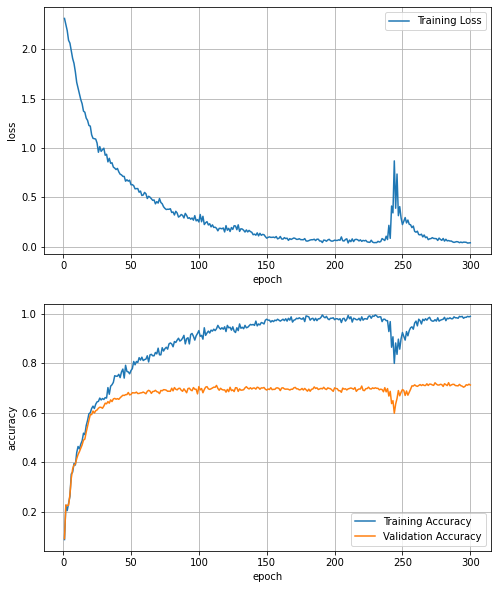

In [12]:
trainer.run_trainer()

In [14]:
## Evaluate the article retrieval system ##
PATH = 'GNN.model'
torch.save(model, PATH)


# Task 2

In [15]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc

## Data Process


In [16]:
## Build the anomaly detection model ##

In [17]:
GNNPATH = 'drive/MyDrive/GNN.model'
GNN_model = torch.load(GNNPATH)
GNN_model.eval()



GraphSAGE(
  (conv1): SAGEConv(300, 32)
  (conv2): SAGEConv(32, 32)
  (conv3): SAGEConv(32, 10)
)

In [18]:
## Download the anomaly evaluation data ##
data_2 = download('https://surfdrive.surf.nl/files/index.php/s/EzMkh3SZbsbJb2i/download', filetype='tensor')
is_anomaly = download('https://surfdrive.surf.nl/files/index.php/s/wrK5xipcIC9DHhu/download', filetype='pickle')

In [19]:
total_node = data_2.x.shape[0]
total_edge = data_2.edge_index.shape[1]
new_node = total_node - num_node
new_edge = total_edge - num_edge
print(f'Num new nodes: {new_node}')
print(f'Num new edges: {new_edge}')

Num new nodes: 2000
Num new edges: 50176


In [20]:
print(f'Indices of new nodes are {num_node}...{total_node-1}')
print('The first 1000 are real articles, the last 1000 are anomaly articles')
print('You can use the map "is_anomaly" to identify whether a node is an anomaly or not')
e_real = num_node+500
e_anomaly = num_node+1500
print(f'E.g., is_anomaly[{e_real}] = {is_anomaly[e_real]} and is_anomaly[{e_anomaly}] = {is_anomaly[e_anomaly]}')

Indices of new nodes are 10701...12700
The first 1000 are real articles, the last 1000 are anomaly articles
You can use the map "is_anomaly" to identify whether a node is an anomaly or not
E.g., is_anomaly[11201] = 0 and is_anomaly[12201] = 1


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(data_1)
#print(data_2)

num_node_feature2 = data_1.x.shape[1]
num_class2 = int(max(data_1.y)+1)
num_label2 = sum(data_1.train_mask)


print(f'Num node features: {num_node_feature2}')
print(f'Num classes: {num_class2}')
print()
print(f'Num training labels: {num_label2}')


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

GNN_model.conv2.register_forward_hook(get_activation('conv2'))
#x = torch.randn(1, 25)
outputs = GNN_model(data_2.x.to(device), data_2.edge_index.to(device)).tolist()

Num node features: 300
Num classes: 10

Num training labels: 522


In [53]:
#embeddings = activation['conv2'].cpu().tolist()
#embeddings = data_2.x.to(device).tolist()
embeddings = outputs
#print(embeddings)


In [54]:
train_dataset = embeddings[:num_node]
normal_test= embeddings[num_node : num_node + 1000]
anomaly_test= embeddings[num_node + 1000 : ]
#print(normal_test)

In [55]:
batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_dataset), torch.tensor(np.zeros((len(train_dataset)), dtype=int)))
normal_test =  torch.utils.data.TensorDataset(torch.tensor(normal_test), torch.tensor(np.zeros((len(normal_test)), dtype=int)))
anomaly_test = torch.utils.data.TensorDataset(torch.tensor(anomaly_test), torch.tensor(np.zeros((len(anomaly_test)), dtype=int)))

# setup DataLoaders
normal_loader_train = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
normal_loader_test = DataLoader(dataset=normal_test, batch_size=batch_size, shuffle=True, **kwargs)
anomaly_loader_test = DataLoader(dataset=anomaly_test, batch_size=batch_size, shuffle=True, **kwargs)


## Model

In [57]:
# VAE model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(DEVICE)
        z = mu + sigma * epsilon
        
        return z

In [58]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr

In [59]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, mu, log_sigma

In [60]:
x_dim  = len(train_dataset[0][0])
hidden_dim = 500
latent_dim = num_class
print(x_dim, hidden_dim, latent_dim)

cuda = True  # NOTE: if running in Google Colab, make sure to go to "Edit > Notebook settings" and set "Hardware accelerator" to "GPU"
DEVICE = torch.device("cuda" if cuda else "cpu")

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)

10 500 10


In [61]:
vae.eval()

VAE(
  (encoder): Encoder(
    (fc_input): Linear(in_features=10, out_features=500, bias=True)
    (fc_hidden): Linear(in_features=500, out_features=500, bias=True)
    (fc_mu): Linear(in_features=500, out_features=10, bias=True)
    (fc_sigma): Linear(in_features=500, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (fc_hidden1): Linear(in_features=10, out_features=500, bias=True)
    (fc_hidden2): Linear(in_features=500, out_features=500, bias=True)
    (fc_output): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [62]:
lr = 1e-3

def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=lr)

## Training

In [63]:
#training 
epochs = 200

print("Start training VAE...")
vae.train()

for epoch in tqdm(range(epochs)):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(normal_loader_train):
        #print(x.shape)
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_reconstr, mu, log_sigma = vae(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    if epoch % 20 == 0:
      print('Epoch: {}, Avg_loss: {}, Reconstr_loss: {}, KL_loss: {}'.format(epoch, overall_loss/n_datapoints, overall_reconstr_loss/n_datapoints, overall_kl_loss/n_datapoints))
   
print()   
print("Training complete!")

  0%|          | 0/200 [00:00<?, ?it/s]

Start training VAE...


  0%|          | 1/200 [00:00<02:04,  1.59it/s]

Epoch: 0, Avg_loss: 1810.7519638831593, Reconstr_loss: 1797.1519972300307, KL_loss: 13.599965212935599


 10%|█         | 21/200 [00:12<01:49,  1.64it/s]

Epoch: 20, Avg_loss: 1789.80194566388, Reconstr_loss: 1788.494687477183, KL_loss: 1.3072578502369818


 20%|██        | 41/200 [00:24<01:34,  1.69it/s]

Epoch: 40, Avg_loss: 1789.0970909389603, Reconstr_loss: 1788.1351355664974, KL_loss: 0.9619606602971799


 30%|███       | 61/200 [00:35<01:19,  1.75it/s]

Epoch: 60, Avg_loss: 1789.1120214501498, Reconstr_loss: 1788.1011791878102, KL_loss: 1.0108413702750874


 40%|████      | 81/200 [00:47<01:10,  1.69it/s]

Epoch: 80, Avg_loss: 1788.9734457140771, Reconstr_loss: 1787.939166550681, KL_loss: 1.0342794908541386


 50%|█████     | 101/200 [00:59<00:57,  1.72it/s]

Epoch: 100, Avg_loss: 1788.6965665385878, Reconstr_loss: 1787.9036555637824, KL_loss: 0.7929082571513185


 60%|██████    | 121/200 [01:10<00:46,  1.71it/s]

Epoch: 120, Avg_loss: 1788.6755082007435, Reconstr_loss: 1787.8400346078606, KL_loss: 0.8354732299408066


 70%|███████   | 141/200 [01:22<00:34,  1.73it/s]

Epoch: 140, Avg_loss: 1788.8889517810858, Reconstr_loss: 1787.9057385367992, KL_loss: 0.983214120123988


 80%|████████  | 161/200 [01:34<00:22,  1.71it/s]

Epoch: 160, Avg_loss: 1788.7803961637978, Reconstr_loss: 1787.892629308968, KL_loss: 0.8877735568429822


 90%|█████████ | 181/200 [01:45<00:11,  1.71it/s]

Epoch: 180, Avg_loss: 1788.9152654744087, Reconstr_loss: 1787.9342647260148, KL_loss: 0.9810007400546118


100%|██████████| 200/200 [01:56<00:00,  1.71it/s]


Training complete!


In [64]:
PATH = 'VAE.model'
torch.save(vae, PATH)

## Evaluation



In [65]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

In [66]:
#vae.eval()

x_original_list_normal = []
x_reconstr_list_normal = []
elbos_normal = []
x_original_list_anomaly = []
x_reconstr_list_anomaly = []
elbos_anomaly = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(normal_loader_test)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_reconstr, mu, log_sigma = vae(x)
        elbo, reconstr_loss, kl_loss = elbo_elementwise(x, x_reconstr, mu, log_sigma)

        x_original_list_normal.append(x)
        x_reconstr_list_normal.append(x_reconstr)
        elbos_normal.append(elbo.cpu().numpy())
    
    for batch_idx, (x, y) in enumerate(tqdm(anomaly_loader_test)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_reconstr, mu, log_sigma = vae(x)
        elbo, reconstr_loss, kl_loss = elbo_elementwise(x, x_reconstr, mu, log_sigma)

        x_original_list_anomaly.append(x)
        x_reconstr_list_anomaly.append(x_reconstr)
        elbos_anomaly.append(elbo.cpu().numpy())

elbos_normal = np.concatenate(elbos_normal)  # loss values represent *negative* ELBO values
elbos_anomaly = np.concatenate(elbos_anomaly)

100%|██████████| 10/10 [00:00<00:00, 89.34it/s]


### Density Plot

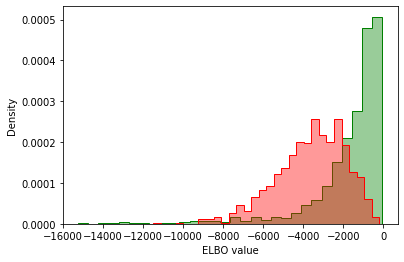

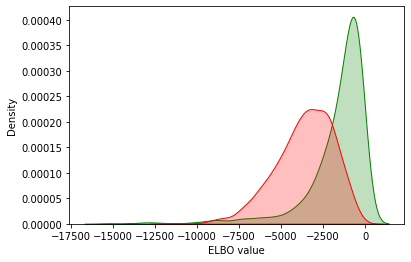

In [67]:
def density_histogram(neg, pos, bins=30, alpha=0.4):
    plt.figure()
    plt.hist(neg, bins=bins, density=True, histtype="bar", color="g", alpha=alpha)
    plt.hist(neg, bins=bins, density=True, histtype="step", color="g", alpha=1)
    plt.hist(pos, bins=bins, density=True, histtype="bar", color="r", alpha=alpha)
    plt.hist(pos, bins=bins, density=True, histtype="step", color="r", alpha=1)
    plt.xlabel("ELBO value")
    plt.ylabel("Density")
    plt.show()


def density_plot(neg, pos):
    plt.figure()
    sns.kdeplot(neg, shade=True, color="g")
    sns.kdeplot(pos, shade=True, color="r")
    plt.xlabel("ELBO value")
    plt.ylabel("Density")

density_histogram(elbos_normal, elbos_anomaly)
density_plot(elbos_normal, elbos_anomaly)

### ROC-AUC

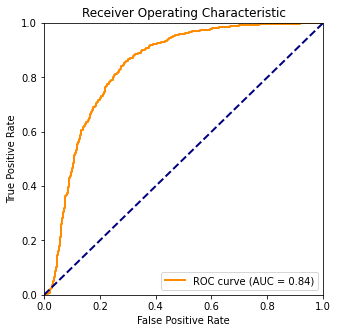

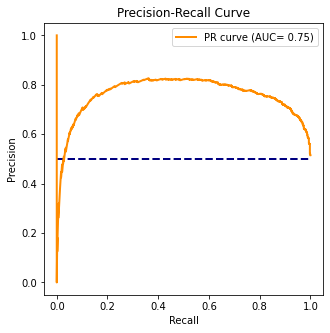

In [68]:
def roc_pr_curves(neg, pos):
    # translate to scores from 0 to 1, where 1 means anomaly (low ELBO) and 0 means normal (high ELBO)
    min_val = min(np.min(neg), np.min(pos))
    max_val = max(np.max(neg), np.max(pos))
    y_true_neg = np.zeros(neg.shape)
    y_true_pos = np.ones(pos.shape)
    y_true = np.concatenate((y_true_neg, y_true_pos))
    y_score = (max_val - np.concatenate((neg, pos))) / (max_val - min_val)

    # get ROC curve values
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=True)
    auroc = auc(fpr, tpr)

    # plot ROC curve
    lw = 2
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # get Precision-Recall values
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auprc = auc(recall, precision)

    # plot Precision-Recall curve
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [no_skill, no_skill], color="navy", lw=lw, linestyle='--')
    plt.plot(recall, precision, color='darkorange',
             lw=lw, label="PR curve (AUC= %0.2f)" % auprc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.show()

roc_pr_curves(elbos_normal, elbos_anomaly)